In [64]:
from skimage import io, filters
from skimage.transform import resize
import numpy as np
import glob
import matplotlib.pyplot as plt

dim = (36, 36)

def filter_and_flatten(filename):
    image = io.imread(filename, as_gray=True)
    image = resize(image, dim)
    threshold = filters.threshold_otsu(image)
    binary = image > threshold
    return binary.flatten()

def data_input(directory, labels):
    X = []
    Y = []
    for label in labels:
        for filename in glob.glob('{}/{}/*'.format(directory, label)):
            binary = filter_and_flatten(filename)
            X.append(binary)
            Y.append(label)
    return np.array(X), np.array(Y)

    
labels = ["triangle", "circle", "square", "heart", "star"]
directory = "."
X, Y = data_input(directory, labels)

print("Number of images: {}".format(X.shape[0]))

# Display info on example image
print(X[0].shape)
print(Y[0])


Number of images: 94
(1296,)
triangle


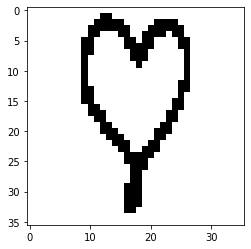

In [65]:
plt.imshow(X[57].reshape(dim), cmap=plt.cm.gray)

Nearest neighbors: 1
Nearest neighbors: 3
Nearest neighbors: 5
Nearest neighbors: 7
Nearest neighbors: 9


Text(0.5, 1.0, 'Y training labels distribution')

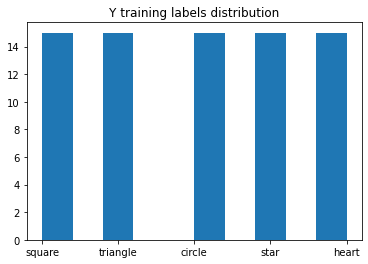

In [66]:
# kNN model

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.neighbors import KNeighborsClassifier

# Define number of k-folds
fold = 10

# Keep list of accuracies in cross-validation
knn_scores = {}

# Defining various k nearest neighbours
for k in range(1, 10, 2):
    sss = StratifiedShuffleSplit(n_splits=fold, test_size=0.2, random_state=0)
    split = sss.split(X, Y)

    neigh = KNeighborsClassifier(n_neighbors=k)
    print("Nearest neighbors: {}".format(k))
    accuracies = []

    for train_index, val_index in split:
        #print("TRAIN:", train_index, "VALIDATION:", val_index)
        X_train, X_val = X[train_index], X[val_index]
        Y_train, Y_val = Y[train_index], Y[val_index]
        neigh.fit(X_train, Y_train)
        #print("Accuracy: {}".format(neigh.score(X_test, Y_test)))
        accuracies.append(neigh.score(X_val, Y_val))
    
    knn_scores[k] = accuracies
    
plt.hist(Y_train)
plt.title("Y training labels distribution")

In [67]:
# MLP (Multi-layered perceptron) model

from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score

mlp = MLPClassifier(max_iter=500)
sss = StratifiedShuffleSplit(n_splits=fold, test_size=0.2, random_state=0)
mlp_scores = cross_val_score(mlp, X, Y, cv=sss)
print(mlp_scores)


[0.73684211 0.36842105 0.68421053 0.47368421 0.47368421 0.57894737
 0.57894737 0.47368421 0.57894737 0.63157895]


In [68]:
# LR (Logistic regression) model
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(multi_class='multinomial', max_iter=1500)
sss = StratifiedShuffleSplit(n_splits=fold, test_size=0.2, random_state=0)
lr_scores = cross_val_score(lr, X, Y, cv=sss)
print(lr_scores)

[0.73684211 0.42105263 0.63157895 0.47368421 0.52631579 0.42105263
 0.57894737 0.57894737 0.52631579 0.68421053]


Text(0.5, 1.0, 'Accuracies depending on model')

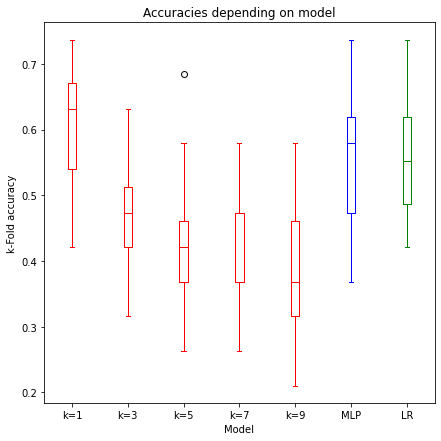

In [69]:
# Graph results of cross-validation depending on model

c1 = 'r'
c2 = 'b'

median_c = 'orange'
fig = plt.figure(figsize=(7, 7))
def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['medians'], color=color)
    plt.setp(bp['fliers'], color=color)

for k in range(1, 10, 2):
    p = (k-1)/2
    bp = plt.boxplot((knn_scores[k]), positions=[p])
    set_box_color(bp, c1)

bp = plt.boxplot(mlp_scores, positions=[5])
set_box_color(bp, c2)

bp = plt.boxplot(lr_scores, positions=[6])
set_box_color(bp, 'g')

x_labels = ["k=1", "k=3", "k=5", "k=7", "k=9", "MLP", "LR"]
plt.xticks(np.arange(7), x_labels)
plt.xlabel("Model")
plt.ylabel("k-Fold accuracy")
plt.title("Accuracies depending on model")

In [70]:
# Take in test data
directory = "test"
X_test, Y_test = data_input(directory, labels)
print("Number of test images: {}".format(X_test.shape[0]))

Number of test images: 20


In [71]:
# Retrain on the entire dataset and test kNN scores
knn_test_scores = {}
for k in range(1, 10, 2):
    neigh = KNeighborsClassifier(n_neighbors=k)
    neigh.fit(X, Y)
    knn_test_scores[k] = neigh.score(X_test, Y_test)
    #print(neigh.predict(X_test))

In [72]:
# Obtain test score for MLP
mlp = MLPClassifier(random_state=1, max_iter=300)
mlp.fit(X, Y)
mlp_test_score = mlp.score(X_test, Y_test)
#print(mlp_test_score)

# Test score for linear regression
lr = LogisticRegression(multi_class='multinomial', max_iter=1500)
lr.fit(X, Y)
lr_test_score = lr.score(X_test, Y_test)

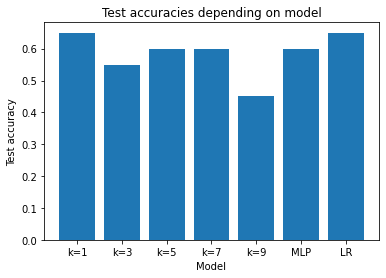

In [73]:
# Display test scores
plt.bar(np.arange(7), 
        list(knn_test_scores.values())+[mlp_test_score, lr_test_score], 
        align='center')
plt.xticks(np.arange(7), x_labels)
plt.xlabel("Model")
plt.ylabel("Test accuracy")
plt.title("Test accuracies depending on model")
plt.show()

# User section

In [74]:
def prediction_input(directory):
    X_pred = []
    for filename in glob.glob('{}/*'.format(directory)):
        binary = filter_and_flatten(filename)
        X_pred.append(binary)
    return np.array(X_pred)

directory = "input"
X_pred = prediction_input(directory)

neigh = KNeighborsClassifier(n_neighbors=1)
neigh.fit(X, Y)
if (len(X_pred) > 0):
    print(neigh.predict(X_pred))


['square']
